# CIBER Research - February 2022



## Tasks
- [x] Read Papers
- [x] Review Source Code
- [ ] Attempt to recreate results from paper
  - [ ] Figure out how to use labels and strengths from the pre-processed data
  - [ ] Create spectrograms from the pre-processed data
  - [ ] Attempt SVM with pre-processed data
  - [ ] Preprocess partitioned blocks
- [ ] Allow for saving and loading blocks in csv files
- [ ] Get spectrogram for all blocks
  - [ ] Store mel spectrogram in csv

## Task Results
**2022/02/15 - 2022/03/01**
* Read paper 1
* Setup parsing for paper 1 timestamps
* Started reading sound files and converting to Mel spectrograms

**2022/03/02 - 2022/03/22**
* Extracted Labels
* Split audio into appropriate chunks
* Standardized audio lengths to given block size

**2022/03/23 - 2022/04/11**
* Attempted to partition all data
* Experimented with csv writing and created `save_blocks_to_csv(blocks, csv_name)` function
  * Saves blocks to csv to allow future quick-loads instead of extensive partitioning times
  * Goal: decrease partitioning time in the long run
  * Goal: getting spectrograms for all blocks

## Relevant Info
**Email from Dr. Hyoseung Kim**
> Some materials to discuss:  
> Paper 1:  I. Nolasco and E. Benetos, “To bee or not to bee: Investigating machine learning approaches to beehive sound recognition,” in Workshop on Detection and Classification of Acoustic Scenes and Events (DCASE), 2018. https://dcase.community/documents/workshop2018/proceedings/DCASE2018Workshop_Nolasco_131.pdf  
> Paper 2: Nolasco, Inês, et al. "Audio-based identification of beehive states." ICASSP 2019-2019 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP). IEEE, 2019. https://arxiv.org/abs/1811.06330
>
> Source code: https://github.com/inesnolas/Audio_based_identification_beehive_states
> 
> Data sets:  
> Paper 1: https://zenodo.org/record/1321278#.YgwykN_MJHe  
> Paper 2: https://zenodo.org/record/2563940#.Ygw85N_MJHe

**API Documentation**
* Keras: https://keras.io/api/
* Seaborn: https://seaborn.pydata.org/api.html
* Pandas: https://pandas.pydata.org/docs/reference/index.html#api
* Numpy: https://numpy.org/doc/stable/reference/index.html#reference
* Librosa: https://librosa.org/doc/main/index.html

# Preprocessing

In [1]:
# imports
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import librosa
import librosa.display
from sklearn import svm
from glob import glob
import warnings
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import os
import platform

warnings.filterwarnings('ignore')

n_fft = 1024
hop_length = 315

os_system = platform.system()

In [2]:
print(os.getcwd())
print(platform.system())

E:\UCR\CIBER\Task 1
Windows


### Parsing Data

In [3]:
# get file lists for both file extensions
def get_files(dir):
    labs = glob(dir + '/*.lab')
    mp3s = glob(dir + '/*.mp3')
    wavs = glob(dir + '/*.wav')
    return labs, mp3s, wavs

In [4]:
if os_system == "Windows":
    directory = 'Data'
else:
    directory = '/content/drive/Shareddrives/CIBER Research Undergrads/Task 1/Data'

parsed_dir = os.path.join(directory[:-4], f"pickles").replace("\\","/")
labs, mp3s, wavs = get_files(directory)
if not os.path.exists(parsed_dir):
    os.mkdir(parsed_dir) 
if not os.path.exists(parsed_dir + "/_ParsedSounds.txt"):  # create txt file with all parsed sound names
    f = open(parsed_dir + "/_ParsedSounds.txt", "w+")
    f.close()
psf = open(parsed_dir + "/_ParsedSounds.txt", "r")
psfn = psf.read().splitlines()
psf.close()

# print(mp3s)

In [5]:
# from os import walk

# f = []
# for (dirpath, dirnames, filenames) in walk(directory):
#     f.extend(filenames)
#     break

# print(labs)
# print(psfn)
print(parsed_dir)
# print(f)
print(directory)

pickles
Data


In [6]:
class SoundBites:
    timestamps = []
    file_path = ""
    sound_type = ""

    def __init__(self, file_path, sound_type="mp3", timestamps=[]):
        self.file_path = file_path
        self.sound_type = sound_type
        self.timestamps=[]

    def __str__(self):
        tmpstr = f"Directory: {self.file_path}\nSound Type: {self.sound_type}\n{self.timestamps}"
        return tmpstr

In [7]:
# parsing .lab files
def parse(data, mp3s, wav, dir):
    sound = SoundBites(f"{dir}/{data[0]}", sound_type="mp3" if f"{dir}/{data[0]}.mp3" in mp3s else "wav")
    for dat in data[1:-2]:
        sound.timestamps.append(dat.split('\t'))
    return sound

In [8]:
data = []
for l in labs:
    with open(l) as file:
        input_string = file.read()
    data.append(parse([x for x in input_string.split('\n')], mp3s, wavs, directory))

# for i in data:
#   print(i)

### Reading Data to Spectrogram

In [9]:
# testing librosa
print(data)
# cut audio files into set length(source code does 60 seconds), segments shorter are repeated until len met
y, sr = librosa.core.load(f"{data[1].file_path}.{data[1].sound_type}", offset=float(data[1].timestamps[1][0]), duration = float(data[1].timestamps[1][1])-float(data[1].timestamps[1][0]))
# y, sr = librosa.core.load(f"{data[1].file_path}.{data[1].sound_type}")
S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length)
S_DB = librosa.power_to_db(S, ref=np.max)
print(S.shape)

[<__main__.SoundBites object at 0x00000215401B0AF0>, <__main__.SoundBites object at 0x00000215401925B0>, <__main__.SoundBites object at 0x00000215401B0EB0>, <__main__.SoundBites object at 0x00000215401B0E80>, <__main__.SoundBites object at 0x00000215FCD90E20>, <__main__.SoundBites object at 0x00000215FCD90BE0>, <__main__.SoundBites object at 0x00000215FCDAE040>, <__main__.SoundBites object at 0x00000215FCDAE3A0>, <__main__.SoundBites object at 0x00000215FCDAE460>, <__main__.SoundBites object at 0x00000215FCDAE430>, <__main__.SoundBites object at 0x00000215FCDAE4F0>, <__main__.SoundBites object at 0x00000215FCDAE5E0>, <__main__.SoundBites object at 0x00000215FCDAE640>, <__main__.SoundBites object at 0x00000215FCDAE730>, <__main__.SoundBites object at 0x00000215FCDAE160>, <__main__.SoundBites object at 0x00000215FCDAE820>, <__main__.SoundBites object at 0x00000215FCDAE850>, <__main__.SoundBites object at 0x00000215FCDAE700>, <__main__.SoundBites object at 0x00000215FCDAE910>, <__main__.S

# Evaluation

### SVM
Initial Parameters (**C\***):  
* Kernel: RBF
* Features: $μ$ and $σ$, $\Delta$ of 20 MFCCs and of the $\Delta\Delta$ of 20 MFCCs
* No Normalisation
* Segment Size ($S$): 60 seconds
* Threshold $\Theta$: 5 seconds
* Split Mode: Random Split

In [10]:
# dataclass to store relevant info for the blocks
class block:
    def __init__(self, weight, nobee, clip = []):
        self.nobee = nobee
        self.weight = weight
        self.clip = clip

In [11]:
from librosa.core.convert import frames_to_time
def get_annotations_for_block(annotations: list, block_start: float, block_finish: float, threshold=0):

    assert block_start < block_finish, (f'block_start ({block_start}) needs to be less than block_finish ({block_finish})')

    timeframes = []
  # annotation_filename = filename[:-4] +'.lab'
  # filename: whatever.mp3 or wav -> filename[0:-4] + .lab

    overlap = 0

  # for frame in open(annotation_filename, 'r').readlines()[1:-1]:  # parse everything except title and end .
    for frame in annotations:
        split = [part.strip() for part in frame.split('\t')]

        assert (len(split)==3), ('expected 3 fields in each line, got: '+str(len(split))) 
    
        frame_start = float(split[0])
        frame_end = float(split[1])
        label = split[2]

        if block_start > frame_end:
            continue
        elif block_finish < frame_start:
            break
        else:
      # start calculations

            if frame_end - frame_start >= threshold and label == 'nobee': # ignores too short thresholds

                if frame_start > block_start and frame_start <= block_finish and frame_end >= block_finish:  
                    # frame overlaps with right of block
                    # |____________########|########
                    # bs          tp0      bf      tp1 
                    overlap += block_finish - frame_start

                elif frame_start <= block_start and frame_end > block_start and frame_end < block_finish:
                    # frame overlaps with left of block
                    # #####|########_____|
                    # tp0  bs     tp1    bf
                    overlap += frame_end - block_start

                elif frame_start > block_start and frame_start <= block_finish and frame_end > block_start and frame_end <= block_finish:
                    # frame completely inside block      
                    # |_____########_____|
                    # bs   tp0    tp1    bf
                    overlap += frame_end - frame_start

                elif frame_start <= block_start and frame_end > block_finish:
                    # frame completely surrounds block
                    #  ####|############|####
                    # tp0  bs           bf  tp1
                    overlap += block_finish - block_start
    
    final_label = 'nobee' if overlap > threshold else 'bee'
    return [overlap/(block_finish-block_start), final_label]
 
  # return timeframes

In [12]:
def get_blocks_from_filename(filename: str, block_size: int, threshold: float): 
    
    '''
  Returns array of all blocks in provided audiofile
  Each returned block in the array is length of 2:
    - [0] is sound data
    - [1] is bee/nobee annotation
    
    '''
    
    print(block_size, filename)    
    annotation_filename = filename[:-4] +'.lab'    
    annotations = open(annotation_filename, 'r').readlines()[1:-1]    
    blocks = []    
    offset = 0    
    temp = filename.split('/')[-1]    
    print(f'Reading audio file {temp}')    
    while True:    
        # clear_output()    
        print(f'\Attempting to read from {offset}s to {offset+block_size}s...')    
        try:    
            clip, sr = librosa.core.load(filename, offset=offset, duration=block_size)
        except ValueError as error:
            clip = np.arange(0)
    
    # print(clip.shape[0] / sr)
        if clip.shape[0] >= block_size * sr:
            annotation = get_annotations_for_block(annotations, offset, offset+block_size, threshold)
            newBlock = block(annotation[0], annotation[1], clip)
            blocks.append(newBlock)
      # ret.append([clip, annotation])
            block_name = f'{temp[:-4]} timestamp{offset}-{offset+block_size} {annotation[1]} {round(annotation[0], 5)}'
            print(block_name)

        elif clip.shape[0] > 0:
            annotation = get_annotations_for_block(annotations, offset, offset+block_size, threshold)
      # ret.append([np.pad(clip, (0, block_size*sr-clip.shape[0]), mode='reflect'), annotation])
            newBlock = block(annotation[0], annotation[1], np.pad(clip, (0, block_size*sr-clip.shape[0]), mode='reflect'))
            blocks.append(newBlock)
            block_name = f'{temp[:-4]} timestamp {offset}-{round(clip.shape[0]/sr, 2)} {annotation[1]} {round(annotation[0], 5)}'
            print(block_name)
            print(f"----- Finished {temp}")
            break

        else:
            print(f"----- Finished {temp}")
            break

        offset += block_size
    return blocks

In [13]:
# def save_blocks_to_csv(blocks, csv_name):
#   csvarray = np.array(blocks)
#   np.savetxt(directory + csv_name, csvarray, delimiter=',')
#   pass

In [14]:
psf = open(parsed_dir + "/_ParsedSounds.txt", "r")
psfn = psf.read().splitlines()
psf.close()
print(psfn)

['CF003 - Active - Day - (214).wav', '[0, 0, 0, 0, 0]', 'CF003 - Active - Day - (215).wav', '[0, 0, 0, 0, 0]', 'CF003 - Active - Day - (216).wav', '[1, 1, 1, 1, 1]', 'CF003 - Active - Day - (217).wav', '[0, 1, 0, 1, 0]', 'CF003 - Active - Day - (218).wav', '[1, 1, 0, 0, 0]', 'CF003 - Active - Day - (219).wav', '[1, 1, 0, 1, 1]', 'CF003 - Active - Day - (220).wav', '[1, 1, 1, 1, 1]', 'CF003 - Active - Day - (221).wav', '[1, 1, 0, 1, 1]', 'CF003 - Active - Day - (222).wav', '[1, 1, 1, 1, 1]', 'CF003 - Active - Day - (223).wav', '[0, 1, 1, 1, 1]', 'CF003 - Active - Day - (224).wav', '[1, 1, 1, 1, 1]', 'CF003 - Active - Day - (225).wav', '[1, 1, 1, 1, 1]', 'CF003 - Active - Day - (226).wav', '[1, 0, 1, 1, 1]', 'CF003 - Active - Day - (227).wav', '[0, 1, 1, 0, 1]', 'CJ001 - Missing Queen - Day -  (100).wav', '[0, 0, 0, 0, 0]', 'CJ001 - Missing Queen - Day -  (101).wav', '[1, 0, 0, 0, 0]', 'CJ001 - Missing Queen - Day -  (102).wav', '[0, 0, 1, 1, 0]', 'CJ001 - Missing Queen - Day -  (103).wa

In [15]:
sound_arr = []
notation_arr = []

psf = open(parsed_dir + "/_ParsedSounds.txt", "a")
# goes through each soundfile, parses, and saves mel spectrogram of blocks
# TODO: make a registry containing all existing soundfiles. Only parse and save if it doesn't exist
for audio in (wavs + mp3s):
    audio_filename = audio.replace(directory, "")[1:]

    if audio_filename not in psfn:
        parsed_audio = get_blocks_from_filename(audio, 60, 1)
        tmp_notation_arr = []
        for idx, audio_block in enumerate(parsed_audio):
            spec = librosa.feature.melspectrogram(audio_block.clip, sr=sr, n_fft=n_fft, hop_length=hop_length)
            sound_arr.append(spec)
            if audio_block.nobee == "nobee": 
                notation_arr.append(0)
                tmp_notation_arr.append(0)
            elif audio_block.nobee == "bee":
                notation_arr.append(1)
                tmp_notation_arr.append(1)
            else:
                exit(-1)
            pd.DataFrame(spec).to_csv(os.path.join(parsed_dir, f"{audio_filename}_block_{idx}.csv"))

        psf.write(audio_filename + "\n")
        psf.write(str(tmp_notation_arr) + "\n")
        psfn.append(audio_filename)
        psfn.append(tmp_notation_arr)
    else:
        i = 0
        parsed_csv_file = os.path.join(parsed_dir, f"{audio_filename}_block_{i}.csv")
        while os.path.exists(parsed_csv_file):
            print(f"Loaded {parsed_csv_file} from save")
            df = pd.read_csv(parsed_csv_file)
            del df["Unnamed: 0"]
            sound_arr.append(df.to_numpy())
            i += 1
            parsed_csv_file = os.path.join(parsed_dir, f"{audio_filename}_block_{i}.csv")
        notations = [int(n) for n in psfn[psfn.index(audio_filename) + 1].lstrip("[").rstrip("]").split(", ")]
        print(notations)
        notation_arr = np.append(notation_arr, notations)

mfccs = [librosa.feature.mfcc(S=s, n_mfcc=20) for s in sound_arr]
input_arr = np.array(mfccs)
input_arr = input_arr.reshape(input_arr.shape[0], input_arr.shape[1] * input_arr.shape[2])
psf.close()
    # tmp_file = open(os.path.join(directory[:-5], "pickles/sound" + str(idx) + ".txt"), "wb")
    # annotation = audio_block.nobee == 'bee'
    # pickle.dump(spec, tmp_file)
    # tmp_file.close()
    # for index, i in enumerate(spec):
    #   sound_arr.append([os.path.split(audio)[-1], idx, index, i])

Loaded pickles\CF003 - Active - Day - (214).wav_block_0.csv from save
Loaded pickles\CF003 - Active - Day - (214).wav_block_1.csv from save
Loaded pickles\CF003 - Active - Day - (214).wav_block_2.csv from save
Loaded pickles\CF003 - Active - Day - (214).wav_block_3.csv from save
Loaded pickles\CF003 - Active - Day - (214).wav_block_4.csv from save
[0, 0, 0, 0, 0]
Loaded pickles\CF003 - Active - Day - (215).wav_block_0.csv from save
Loaded pickles\CF003 - Active - Day - (215).wav_block_1.csv from save
Loaded pickles\CF003 - Active - Day - (215).wav_block_2.csv from save
Loaded pickles\CF003 - Active - Day - (215).wav_block_3.csv from save
Loaded pickles\CF003 - Active - Day - (215).wav_block_4.csv from save
[0, 0, 0, 0, 0]
Loaded pickles\CF003 - Active - Day - (216).wav_block_0.csv from save
Loaded pickles\CF003 - Active - Day - (216).wav_block_1.csv from save
Loaded pickles\CF003 - Active - Day - (216).wav_block_2.csv from save
Loaded pickles\CF003 - Active - Day - (216).wav_block_3.cs

Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.wav_block_2.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.wav_block_3.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.wav_block_4.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.wav_block_5.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.wav_block_6.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.wav_block_7.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.wav_block_8.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00.wav_block_9.csv from save
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00.wav_block_0.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00.wav_block_1.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00.wav_block_2.csv from save
Loaded pickl

Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.wav_block_3.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.wav_block_4.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.wav_block_5.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.wav_block_6.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.wav_block_7.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.wav_block_8.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___16_50_00.wav_block_9.csv from save
[0, 0, 0, 0, 1, 0, 1, 1, 0, 0]
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.wav_block_0.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.wav_block_1.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.wav_block_2.csv from save
Loaded pickles\Hive1_12_06_2018_QueenBee_H1_audio___17_00_00.wav_block_3.csv from save
Loaded pickl

Loaded pickles\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.wav_block_2.csv from save
Loaded pickles\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.wav_block_3.csv from save
Loaded pickles\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.wav_block_4.csv from save
Loaded pickles\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.wav_block_5.csv from save
Loaded pickles\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.wav_block_6.csv from save
Loaded pickles\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.wav_block_7.csv from save
Loaded pickles\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.wav_block_8.csv from save
Loaded pickles\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00.wav_block_9.csv from save
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Loaded pickles\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.wav_block_0.csv from save
Loaded pickles\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.wav_block_1.csv from save
Loaded pickles\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_30_00.wav_b

Loaded pickles\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.wav_block_1.csv from save
Loaded pickles\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.wav_block_2.csv from save
Loaded pickles\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.wav_block_3.csv from save
Loaded pickles\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.wav_block_4.csv from save
Loaded pickles\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.wav_block_5.csv from save
Loaded pickles\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.wav_block_6.csv from save
Loaded pickles\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.wav_block_7.csv from save
Loaded pickles\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.wav_block_8.csv from save
Loaded pickles\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00.wav_block_9.csv from save
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
Loaded pickles\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.wav_block_0.csv from save
Loaded pickles\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_30_00.wav_b

Loaded pickles\GH001 - Active - Day - 141022_0659_0751.mp3_block_22.csv from save
Loaded pickles\GH001 - Active - Day - 141022_0659_0751.mp3_block_23.csv from save
Loaded pickles\GH001 - Active - Day - 141022_0659_0751.mp3_block_24.csv from save
Loaded pickles\GH001 - Active - Day - 141022_0659_0751.mp3_block_25.csv from save
Loaded pickles\GH001 - Active - Day - 141022_0659_0751.mp3_block_26.csv from save
Loaded pickles\GH001 - Active - Day - 141022_0659_0751.mp3_block_27.csv from save
Loaded pickles\GH001 - Active - Day - 141022_0659_0751.mp3_block_28.csv from save
Loaded pickles\GH001 - Active - Day - 141022_0659_0751.mp3_block_29.csv from save
Loaded pickles\GH001 - Active - Day - 141022_0659_0751.mp3_block_30.csv from save
Loaded pickles\GH001 - Active - Day - 141022_0659_0751.mp3_block_31.csv from save
Loaded pickles\GH001 - Active - Day - 141022_0659_0751.mp3_block_32.csv from save
Loaded pickles\GH001 - Active - Day - 141022_0659_0751.mp3_block_33.csv from save
Loaded pickles\G

In [16]:
# # np.array(sound_arr[0])
# # print(type(sound_arr))
# print(sound_arr)
# print(notation_arr)
# mfccs = librosa.feature.mfcc(S=sound_arr[0], n_mfcc=20)
input_arr.shape
# input_arr = np.array(mfccs)

(499, 84020)

In [17]:
# df = pd.DataFrame(sound_arr)

6.002433


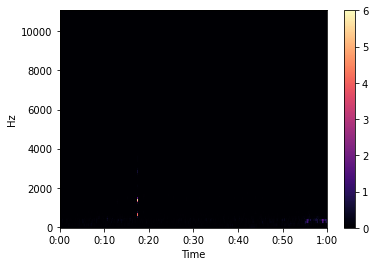

In [18]:
curr_wave = sound_arr[100]
# print(type(sound_arr[100]))
# S = librosa.feature.melspectrogram(curr_wave.data, sr=sr, n_fft=n_fft, hop_length=hop_length)
img = librosa.display.specshow(curr_wave, sr=sr, hop_length=hop_length, y_axis="linear", x_axis="time")
plt.colorbar(img)
print(curr_wave.max())
# print(curr_wave.values)
# curr_wave

In [19]:
# librosa.display.specshow(spec, sr=sr, hop_length=hop_length, y_axis="linear", x_axis="time")

In [20]:
# how to convert pd row intos pec
# librosa.display.specshow(np.vstack(list(df.iloc[-1][2:])), sr=sr, hop_length=hop_length, y_axis="linear", x_axis="time")

In [21]:
# print([audio_block.nobee == 'nobee' for audio_block in parsed_audio])
# print([audio_block.nobee for audio_block in parsed_audio])

In [22]:
# for i in np.unique(notation_arr):
#   print(f'Number of {i}\'s: {notation_arr.count(i)}')

In [23]:
# print(np.array(sound_arr).shape)
# print(notation_arr)

In [24]:

# input_arr = np.array(sound_arr).reshape(len(sound_arr), 128*4201)

# print(input_arr.shape)

In [25]:
# deltas = librosa.feature.mfcc(S=S, n_mfcc=20)
input_arr

array([[ 3.09592174e-04,  9.33361721e-04,  1.08982637e-03, ...,
         1.99343038e-04,  3.29123171e-04,  1.68029157e-04],
       [ 7.64309362e-04,  1.47829355e-03,  7.26450377e-04, ...,
         8.73075263e-05,  1.14945979e-04,  5.92302939e-05],
       [ 1.06128890e-04,  5.79113471e-04,  5.58251030e-04, ...,
         1.97298531e-05, -8.27973880e-06,  3.09620198e-05],
       ...,
       [ 2.88694685e-01,  8.00659565e-01,  7.43637783e-01, ...,
         2.09262518e-01,  1.98558475e-01,  5.92160357e-02],
       [ 1.61715168e-01,  3.61767924e-01,  6.64258303e-01, ...,
         2.72494526e+00,  6.20914109e+00,  1.22017407e+00],
       [ 5.69174815e+00,  6.54000874e+00,  3.55021512e+00, ...,
         3.35779786e+00,  1.19610847e+01,  3.57563984e+00]])

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    input_arr, notation_arr, test_size=0.33, random_state=42)
# print(X_test.shape)
# print(num_features_svm)

In [27]:
# # C_range = np.logspace(-)
# num_features_svm = X_test.shape[0] * X_test.shape[1]
# clf = svm.SVC(kernel='rbf', probability=True, class_weight='balanced', C=1, gamma=(1/num_features_svm))
# # TODO: check paper for gamma value SD: There's no gamma value in the paper
# # gamma: try c value; any values to find best; use lgspace
# # features: \delta -> deriv; \delta\delta -> derive, then sub two derives; use librosa
# # clf.fit([i.flatten() for i in sound_arr], notation_arr)
# clf.fit(input_arr, notation_arr)

In [28]:
from sklearn import model_selection
from sklearn import metrics
num_samples = 2
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [1, 0.1, 0.01, 0.001, 0.0001]
# C_range = np.logspace(-5, 5, num_samples)
# gamma_range = np.logspace(-10, 2, num_samples)
param_grid = {"gamma":gamma_range, "C":C_range}
# num_features_svm = X_test.shape[0] * X_test.shape[1]
# clf = model_selection.GridSearchCV(svm.SVC(), param_grid, scoring=metrics.precision_recall_curve(y_train, X_train))
clf = model_selection.GridSearchCV(svm.SVC(kernel='rbf', probability=True, class_weight='balanced'), 
                                   param_grid, 
                                   scoring="average_precision")
# TODO: check paper for gamma value SD: There's no gamma value in the paper
# gamma: try c value; any values to find best; use lgspace
# features: \delta -> deriv; \delta\delta -> derive, then sub two derives; use librosa
# clf.fit([i.flatten() for i in sound_arr], notation_arr)
clf.fit(X_train, y_train) 

GridSearchCV(estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             scoring='average_precision')

In [34]:
# preds = clf.predict([i.flatten() for i in sound_arr])
# arr = np.array(sound_arr[])
idxs = np.random.choice(len(input_arr), 100)
arr = np.array(input_arr)[idxs]
print(arr.shape)
preds = clf.predict(arr)
for i in np.unique(preds):
    print(f'Number of {i}\'s: {list(preds).count(i)}')

(100, 84020)
Number of 0.0's: 78
Number of 1.0's: 22


In [36]:
# print([notation_arr[idx] for i in idxs])
print(preds)

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 1.]


```
(100, 84020)
Number of 0.0's: 78
Number of 1.0's: 22
```

### CNN
Initial Parameters (**B\***):
* Features: 80 Mel-band spectra
* Segment(Block) Size ($S$): 60 seconds
* Threshold $\Theta$: 0 seconds
* Respective field: 1000 frames
* \# Training Epochs: 100
* Batch Size: 20


CNN Reference: https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

Bulbul: https://github.com/DCASE-REPO/bulbul_bird_detection_dcase2018

Rec Field: https://theaisummer.com/receptive-field/


In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# demeaned = np.newaxis(sound_arr[0].to_numpy())
# demeaned.shape
X = np.array([i - i.mean() for i in sound_arr])
# y = [np.array(i) for i in notation_arr]
Y = np.array(notation_arr)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.05, random_state=42)
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [ ]:
print(X_train.shape, y_train.shape)

In [ ]:
# try w/ max pooling, then others (avg)
# global pooling
# lrelu: try default first
# first layer -> make sure input shape correct (128, 4201)
# paper: look at bulbul -> what is dimension?
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), input_shape=(128, 4201, 1)))
model.add(layers.LeakyReLU())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, (3, 3)))
model.add(layers.LeakyReLU())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, (3, 1)))
model.add(layers.LeakyReLU())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, (3, 1)))
model.add(layers.LeakyReLU())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(256))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(32))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))
model.add(layers.Dropout(0.5))

model.summary()

In [ ]:
# try dif optimizers
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=20, epochs=5, 
                    validation_data=(X_test, y_test))

In [ ]:
model.save("cnn_attempt1.model")


### SVM Comparison with Paper 1

### CNN Comparison with Paper 1